<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/mean_reversion_pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Commodities Mean Reversion Trading Strategy

In its most simple form, all trading strategies can be classified as either momentum or mean reversion strategies. Commodities in particular are often fungible, which means they can be used as substitutes for each other given the right economics. For such fungible commodities pairs this implies both a positive correlation, as well as cointegration. Cointegration simply means that the individual price series for two commodities cannot deviate indefinitely and will revert to some mean value. This project will explore a mean reverting pairs trading strategy for a select universe of cointegrated commodity pairs. An inherent advantage of restricting our universe to commodities only is that these will be naturally free from survivorship bias. The continuous front month futures contract is used throughout.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm # show progress bars

# financial analysis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import yfinance as yf # Yahoo! Finance API

# hyperparameters tuning
from sklearn.model_selection import TimeSeriesSplit

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

### USER INPUT: date range, trading pair, benchmark, risk free rate, hyperparameters

Here the user must specify the date range from when to start applying the strategy. The date range is then split into a training (and cross-validation) set, and test set. The user must also specify the number of days to be put aside for the test set.

Next the user may specify an initial commodities pair which to explore. After the initial exploration is complete, the user will then later on in this project have the opportunity to define a larger commodity pairs universe.

Next we specify the benchmark and risk free rate. This will allow us to measure our portfolio performance against a proxy, as well as calculate our Sharpe and Sortino ratios, respectively.

Finally, the user may choose an initial set of values for the hyperparameters of our strategy. These are parameters which are not learned automatically, but rather require a degree of user experience and judgement. In our strategy, explained in more detail later on, the main hyperparameters are lookback period, entry and exit thresholds, and stop loss width.

A quick note regarding stop loss: there are arguments against adding stop losses in a mean reverting strategy. Instead, with increasing diversion there should be opportunity to scale in further if one believes that the pair should eventually revert to a mean value. However, as the saying goes, markets can stay irrational longer than one can stay solvent, hence a stop loss may prove prudent.

Lastly, we have bundled fees, commissions, slippage and market impact all into one variable, namely as a percentage cost of each trade. Needless to say, this is not reflective of the real world, but a quick and easy approximation that will suffice for this initial exploration of our strategy.

In [2]:
# date range for training and cross-validation set
start_train = '2007-01-01' # YYYY-MM-DD format
test_days = 1826 # get data up to 5 years ago (5*365.2425)
end_train = datetime.now() - timedelta(test_days)

# date range for test set
start_test = datetime.now() - timedelta(test_days-1)
end_test = datetime.now() - timedelta(1)

# commodities pair
product1_name = 'CME SRW' # Soft Red Winter Wheat
product1_ticker = 'ZW=F'
product2_name = 'CME HRW' # Kansas Hard Red Winter Wheat
product2_ticker = 'KE=F'

# benchmark
benchmark_name = 'S&P GSCI' # S&P GSCI
benchmark_ticker = 'GD=F'

# risk free rate
rfr_name = '3M US T-Bill' # 3-month US Treasury Bills
rfr_ticker = '^IRX'

# hyperparameters
lookback = 30 # rolling window for calculating mean and standard deviation
entry_threshold = 2 # Bollinger Bands +/- standard deviation width
exit_threshold = 0 # generate exit signal when mean reverting
stop_loss = 3 # generate exit signal when excessively mean diverting
stationarity_alpha = 0.05 # threshold for Augmented Dicky Fuller (ADF) stationarity test
fees = 0.015 # fees, commissions, slippage, market impact as a % of each transaction

### Fetch ticker data

In [3]:
def create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end):

  # fetch ticker data for one commodities pair as one GET request
  # Yahoo! Finance API rate limits are 60/minute, 360/hour, 8000/day
  pairs_df = yf.download([product1_ticker, product2_ticker], start=start, end=end)['Adj Close']
  cols = [product1_ticker, product2_ticker]
  pairs_df = pairs_df[cols]
  pairs_df.rename(columns={product1_ticker:product1_name, product2_ticker:product2_name}, inplace=True)
  pairs_df.fillna(method='ffill', inplace=True)
  
  return pairs_df

### Calculate spread

There are numerous ways to define a spread between a trading pair. However, for any mean reverting strategy the key is to ensure stationarity, which simply means a constant mean and variance of that spread.

In [4]:
def calculate_spread(pairs_df, lookback):

  # fit a rolling linear regression between the commodities pair
  model = RollingOLS(endog=pairs_df.iloc[:,0],
                     exog=sm.add_constant(pairs_df.iloc[:,1]),
                     window=lookback)
  rolling_res = model.fit()
  params = rolling_res.params.copy()

  # calculate the hedge ratio
  pairs_df['hedge_ratio'] = params.iloc[:,1]
  pairs_df.dropna(inplace=True)

  # method 1: calculate the hedge ratio spread and ADF test statistic
  pairs_df['hedge_ratio_spread'] = pairs_df.iloc[:,0] - pairs_df['hedge_ratio'] * pairs_df.iloc[:,1]
  adf_hedge_ratio_spread = adfuller(pairs_df['hedge_ratio_spread'])

  # method 2: calculate the ratio spread and ADF test statistic
  pairs_df['ratio_spread'] = pairs_df.iloc[:,0] / pairs_df.iloc[:,1]
  adf_ratio_spread = adfuller(pairs_df['ratio_spread'])

  # choose spread with more negative ADF test statistic and append to dataframe
  if adf_hedge_ratio_spread[0] < adf_ratio_spread[0]:
    pairs_df['spread'] = pairs_df['hedge_ratio_spread']
    pairs_df.drop('hedge_ratio_spread', axis=1, inplace=True)
    return pairs_df, adf_hedge_ratio_spread
  else:
    pairs_df['spread'] = pairs_df['ratio_spread']
    pairs_df.drop(columns=['ratio_spread', 'hedge_ratio'], axis=1, inplace=True)
    return pairs_df, adf_ratio_spread

### Test for stationarity

The most simple test for stationarity is a quick visual inspection by plotting the spread as a time series and checking for any presence of a trend or heteroskedasticity. However, a more robust statistical test is the Augmented Dicky-Fuller (ADF) test where a typical $a$ value is 0.05 and we reject the null hypothesis if our p-value is below this threshold. In other words, if our p-value is less than $a$ we may conclude that our data is indeed stationary.

We perform the ADF test on our initial exploratory commodities pair and obtain the results. The more negative the ADF statistic, the more strongly stationary our spread is and thus more suitable for a mean reverting strategy.

In [5]:
def test_stationarity(pairs_df, adf_result, stationarity_alpha):
    
    # perform ADF test to check for stationarity
    if adf_result[1] < stationarity_alpha:
      return (pairs_df, adf_result, True)
    else:
      return (pairs_df, adf_result, False)

In [6]:
# run functions
pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start_train, end_train)
pairs_df, adf_result = calculate_spread(pairs_df, lookback)
pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)

[*********************100%***********************]  2 of 2 completed


In [7]:
# print ADF test statistics
print('ADF statistic:\n%f' % adf_result[0], '\n')
print('p-value: \n%f' % adf_result[1], '\n')
print('Critical values:')
for key, value in adf_result[4].items():
  print('%s @ %.3f' % (key, value))

ADF statistic:
-8.106430 

p-value: 
0.000000 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


### Calculate Bollinger Bands

Any mean reverting strategy will monitor the deviation of the spread from its rolling mean and standard deviation. The most well-known examples are using Bollinger Bands or a Z-score. Our strategy uses Bollinger Bands as its base and defines additional bands to determine stop loss levels.

In [8]:
def calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss):

  # calculate the rolling mean and rolling std
  pairs_df['mean'] = pairs_df['spread'].rolling(window=lookback).mean()
  pairs_df['std'] = pairs_df['spread'].rolling(window=lookback).std()

  # calculate the rolling entry and exit bands, and rolling stop loss bands
  pairs_df['upper_entry'] = pairs_df['mean'] + entry_threshold * pairs_df['std']
  pairs_df['lower_entry'] = pairs_df['mean'] - entry_threshold * pairs_df['std']
  pairs_df['upper_exit'] = pairs_df['mean'] + exit_threshold * pairs_df['std']
  pairs_df['lower_exit'] = pairs_df['mean'] - exit_threshold * pairs_df['std']
  pairs_df['upper_stop_loss'] = pairs_df['mean'] + stop_loss * pairs_df['std']
  pairs_df['lower_stop_loss'] = pairs_df['mean'] - stop_loss * pairs_df['std']

  return pairs_df

### Define trading rules and get signal CONTINUE HERE

Our base strategy is essentially a Bollinger Bands strategy, which means only a few adjustable hyperparameters, namely the lookback window and standard deviation. Another potential adjustment is whether to use a SMA or EWMA, which we will leave as a future exercise.

In [9]:
def get_trading_signals(pairs_df):

  # create signal column {-1, 0, 1}
  pairs_df['signal'] = 0

  # iterating through the time series to determine whether to buy/hold/sell
  # cannot be vectorised as today's trading signal depends on yday's signal
  # as such time complexity will be linear O(N)
  for i in range(1, len(pairs_df)):

    # from hold to sell or buy
    if pairs_df.iloc[i-1, -1] == 0:
      if (pairs_df['spread'][i] < pairs_df['upper_entry'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_entry'][i-1]):
        pairs_df.iloc[i, -1] = -1
      elif (pairs_df['spread'][i] > pairs_df['lower_entry'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['lower_entry'][i-1]):
        pairs_df.iloc[i, -1] = 1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == -1:
      if (pairs_df['spread'][i] < pairs_df['upper_exit'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the upside
      elif (pairs_df['spread'][i] > pairs_df['upper_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['upper_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = -1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == 1:
      if (pairs_df['spread'][i] > pairs_df['lower_exit'][i]) & \
         (pairs_df['spread'][i-1] <= pairs_df['lower_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the downside
      elif (pairs_df['spread'][i] < pairs_df['lower_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] >= pairs_df['lower_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = 1

  return pairs_df

In [10]:
# run functions
pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
pairs_df = get_trading_signals(pairs_df)

### Plot Bollinger Bands and signal

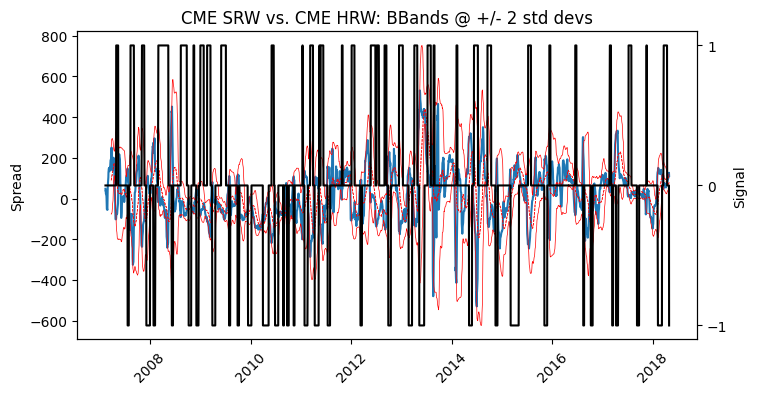

In [11]:
# plot bollinger bands & signal
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.plot(pairs_df.index, pairs_df['spread'])
ax1.plot(pairs_df.index, pairs_df['upper_entry'], color='r', linewidth=0.5, label='upper_entry')
ax1.plot(pairs_df.index, pairs_df['lower_entry'], color='r', linewidth=0.5, label='lower_entry')
ax1.plot(pairs_df.index, pairs_df['upper_exit'], color='r', linewidth=0.5, linestyle='--', label='upper_exit')
ax1.plot(pairs_df.index, pairs_df['lower_exit'], color='r', linewidth=0.5, linestyle='--', label='lower_exit')
ax1.set_ylabel('Spread')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(pairs_df.index, pairs_df['signal'], color='k')
ax2.set_ylabel('Signal')
ax2.set_yticks([-1,0,1])

plt.title(f'{product1_name} vs. {product2_name}: BBands @ +/- {entry_threshold} std devs')
# ax1.legend()
plt.show();

### Get equity curve

In [12]:
def get_equity_curve(pairs_df, product1_name, product2_name, fees):

  pairs_df[f'{product1_name}_returns'] = pairs_df[product1_name].pct_change()
  pairs_df[f'{product2_name}_returns'] = pairs_df[product2_name].pct_change()
  pairs_df['pair_daily_returns'] = pairs_df['signal'].shift() * (1-fees) * (pairs_df[f'{product1_name}_returns'] - pairs_df[f'{product2_name}_returns'])
  pairs_df['pair_cumulative_returns'] = (1 + pairs_df['pair_daily_returns']).cumprod()

  return pairs_df

### Plot equity curve

In [13]:
# run functions
pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)

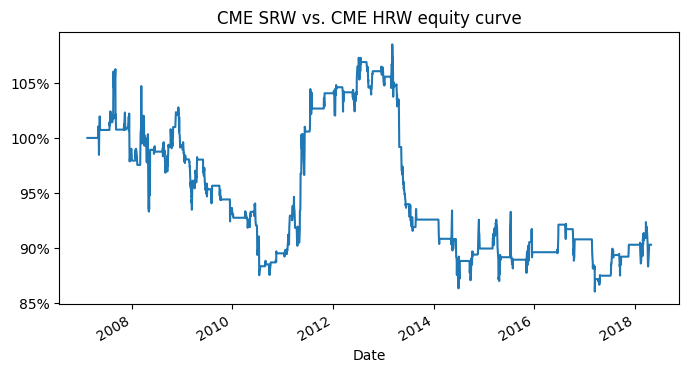

In [14]:
# plot equity curve
fig, ax = plt.subplots(figsize=(8, 4))
plt.title(f'{product1_name} vs. {product2_name} equity curve')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
pairs_df['pair_cumulative_returns'].plot();

### USER INPUT: commodities pairs universe

In [15]:
pairs_universe = [
            
  # AGRICULTURE

            # corn srw
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },

            # corn hrw
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'hrw',
             'product2_ticker':'KC=F'
             },

            # srw hrw
            {'product1_name':'srw', 
             'product1_ticker':'ZW=F',
             'product2_name':'hrw',
             'product2_ticker':'KE=F'
             },

            # soybeans soymeal
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soymeal',
             'product2_ticker':'ZM=F'
             },

            # soybeans soyoil
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

            # soymeal soyoil
            {'product1_name':'soymeal', 
             'product1_ticker':'ZM=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

  # METALS

            # gold silver
            {'product1_name':'gold',
             'product1_ticker':'GC=F',
             'product2_name':'silver',
             'product2_ticker':'SI=F'
             },

            # gold platinum
            {'product1_name':'gold', 
             'product1_ticker':'GC=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

            # silver platinum
            {'product1_name':'silver', 
             'product1_ticker':'SI=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

#   # ENERGY

#             # brent wti
#             {'product1_name':'brent', 
#              'product1_ticker':'BZ=F',
#              'product2_name':'wti',
#              'product2_ticker':'CL=F'
#              },

]

### Get portfolio returns

In [16]:
def get_portfolio_returns(pairs_universe, start, end, lookback, entry_threshold, exit_threshold, stop_loss):

  # create empty list of dataframes
  dfs = []
  columns = []
  total_trades = 0

  # loop through all pairs in universe
  for pair in pairs_universe:

    # convenience variables
    product1_name = pair['product1_name']
    product1_ticker = pair['product1_ticker']
    product2_name = pair['product2_name']
    product2_ticker = pair['product2_ticker']

    # run functions
    pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end)
    pairs_df, adf_result = calculate_spread(pairs_df, lookback)
    pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)

    # proceed only for stationary time series
    if check:

      # run functions
      pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
      pairs_df = get_trading_signals(pairs_df)
      pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)

      # append returns for each pair to dataframe
      pairs_df['pair_cumulative_returns'].fillna(method='ffill', inplace=True)
      dfs.append(pairs_df['pair_cumulative_returns'])
      columns.append(f'{product1_name}_{product2_name}')

      # calculate number of trades
      pairs_df['temp'] = pairs_df['signal'].shift()
      pairs_df['trade_count'] = pairs_df['signal'] != pairs_df['temp']
      del pairs_df['temp']
      total_trades += pairs_df['trade_count'].sum() * 2

  # create dataframe from list and calculate mean returns
  pairs_universe_df = pd.DataFrame(dfs).T
  pairs_universe_df.columns = columns
  pairs_universe_df['portfolio_cumulative_returns'] = pairs_universe_df.mean(axis=1)

  return pairs_universe_df, total_trades

In [17]:
# get portfolio returns
pairs_universe_df, total_trades = get_portfolio_returns(pairs_universe, start_train, end_train,
                                                        lookback, entry_threshold, exit_threshold, stop_loss)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


### Get benchmark returns

In [18]:
def get_benchmark_returns(benchmark_ticker, start, end):

  # get benchmark returns
  bm_df = yf.download([benchmark_ticker], start=start, end=end)
  bm_df.fillna(method='ffill', inplace=True)
  bm_df[f'{benchmark_name}_daily_returns'] = bm_df['Adj Close'].pct_change()
  bm_df[f'{benchmark_name}_cumulative_returns'] = (1 + bm_df[f'{benchmark_name}_daily_returns']).cumprod()

  return bm_df

In [19]:
# run functions
bm_df = get_benchmark_returns(benchmark_ticker, start_train, end_train)

[*********************100%***********************]  1 of 1 completed


### Plot portfolio and benchmark returns

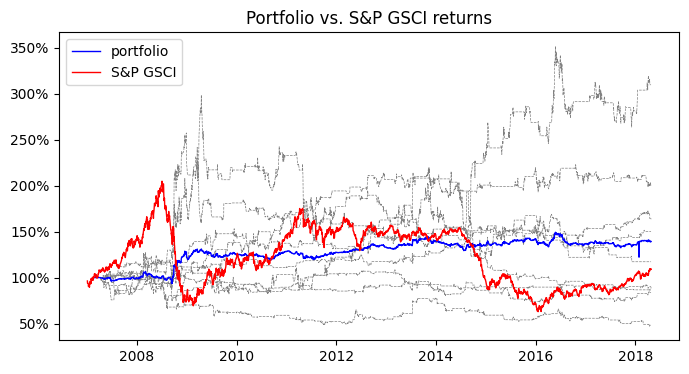

In [20]:
# plot portfolio and benchmark returns
fig, ax = plt.subplots(figsize=(8, 4))

for col in pairs_universe_df.columns[:-1]:
  ax.plot(pairs_universe_df.index, pairs_universe_df[col], color='gray', linewidth=0.5, linestyle='--')
  
ax.plot(pairs_universe_df.index, pairs_universe_df['portfolio_cumulative_returns'],
        color='b', linewidth=1, label='portfolio')
ax.plot(bm_df.index, bm_df[f'{benchmark_name}_cumulative_returns'],
        color='r', linewidth=1, label=f'{benchmark_name}')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title(f'Portfolio vs. {benchmark_name} returns')
plt.legend()
plt.show()

### Get risk free rate

In [21]:
def get_risk_free_rate(rfr_ticker, start, end):

  # get risk free rate
  rfr_df = yf.download([rfr_ticker], start=start, end=end)
  rfr_df['daily_risk_free_rate'] = rfr_df['Adj Close'] / 100 / 252
  rfr_df.fillna(method='ffill', inplace=True)

  return rfr_df

In [22]:
# run functions
rfr_df = get_risk_free_rate(rfr_ticker, start_train, end_train)

[*********************100%***********************]  1 of 1 completed


### Get universe performance metrics

In [23]:
def get_universe_performance_metrics(pairs_universe_df, bm_df, rfr_df):

  # calculate returns in excess of risk free rate
  pairs_universe_df['portfolio_daily_returns'] = pairs_universe_df['portfolio_cumulative_returns'].diff()
  pairs_universe_df['daily_risk_free_rate'] = rfr_df['daily_risk_free_rate']
  pairs_universe_df['excess_returns'] = pairs_universe_df['portfolio_daily_returns'] - pairs_universe_df['daily_risk_free_rate']
  pairs_universe_df.dropna(inplace=True)

  # calculate sharpe ratio
  sharpe_ratio = pairs_universe_df['excess_returns'].mean() / pairs_universe_df['excess_returns'].std()
  sharpe_ratio_annualised = sharpe_ratio * np.sqrt(252)

  # calculate sortino ratio
  downside_returns = pairs_universe_df['excess_returns'][pairs_universe_df['excess_returns'] < 0]
  downside_deviation = downside_returns.std()
  sortino_ratio = pairs_universe_df['excess_returns'].mean() / downside_deviation
  sortino_ratio_annualised = sortino_ratio * np.sqrt(252)

  # calculate max drawdown % from peak to trough
  rolling_max = pairs_universe_df['portfolio_cumulative_returns'].expanding().max()
  drawdown = pairs_universe_df['portfolio_cumulative_returns'] - rolling_max
  max_drawdown = (drawdown / rolling_max).min() * 100

  # calulate portolfio alpha and beta vs. benchmark
  temp_df = pd.concat([pairs_universe_df['portfolio_daily_returns'],
                       bm_df[f'{benchmark_name}_daily_returns']],
                      axis=1).dropna()
  X = sm.add_constant(temp_df.iloc[:,1])
  model = sm.OLS(temp_df.iloc[:,0], X).fit()
  portfolio_alpha, portfolio_beta = model.params

  # print performance metrics
  print(f'Sharpe Ratio: \t\t {round(sharpe_ratio_annualised, 2)}')
  print(f'Sortino Ratio: \t\t {round(sortino_ratio_annualised, 2)}')
  print(f'Maximum drawdown: \t {round(max_drawdown, 2)}%')
  print(f'Alpha vs. {benchmark_name}: \t {round(portfolio_alpha, 4)}')
  print(f'Beta vs. {benchmark_name}: \t {round(portfolio_beta, 4)}')
  print(f'Total # of trades: \t {total_trades}')

  return None

In [24]:
# run functions
get_universe_performance_metrics(pairs_universe_df, bm_df, rfr_df)

Sharpe Ratio: 		 0.45
Sortino Ratio: 		 0.75
Maximum drawdown: 	 -12.17%
Alpha vs. S&P GSCI: 	 0.0002
Beta vs. S&P GSCI: 	 0.0061
Total # of trades: 	 2536


### Get pairs Sharpe Ratio

In [25]:
def get_pairs_sharpe_ratio(pairs_df, rfr_df):

  # calculate returns in excess of risk free rate
  pairs_df['daily_risk_free_rate'] = rfr_df['daily_risk_free_rate']
  pairs_df['excess_returns'] = pairs_df['pair_daily_returns'] - pairs_df['daily_risk_free_rate']

  # calculate sharpe ratio
  sharpe_ratio = pairs_df['excess_returns'].mean() / pairs_df['excess_returns'].std()
  sharpe_ratio_annualised = sharpe_ratio * np.sqrt(252)

  return sharpe_ratio_annualised

### USER INPUT: hyperparameter search space

In [26]:
# hyperparameter search space
lookbacks = list(range(10, 40, 10))
entries = [1.8, 2.2]
exits = [0, 0.5, 0]
stops = [3, 4]

### Optimise hyperparameters

In [27]:
# record sharpe ratios and hyperparameter combo for each commodities pair
results = []

# test all hyperparameter combinations for each commodities pair
for pair in tqdm(pairs_universe[:1], leave=False):

  # record sharpe ratio for each hyperparameter combo for single commodities pair
  sharpes = []

  # convenience variables
  product1_name = pair['product1_name']
  product1_ticker = pair['product1_ticker']
  product2_name = pair['product2_name']
  product2_ticker = pair['product2_ticker']

  # make dataframe copy to avoid repeatedly calling Yahoo! Finance API
  pairs_df_saved = create_pairs_df(product1_name, product1_ticker,
                                   product2_name, product2_ticker,
                                   start_train, end_train)

  # iterate over all possible hyperparameter combinations
  for lookback in tqdm(lookbacks, leave=False):
    for entry in tqdm(entries, leave=False):
      for exit in tqdm(exits, leave=False):
        for stop in tqdm(stops, leave=False):

          # convenience variables
          lookback = lookback
          entry_threshold = entry
          exit_threshold = exit
          stop_loss = stop

          # run functions
          pairs_df = pairs_df_saved.copy()
          pairs_df, adf_result = calculate_spread(pairs_df, lookback)
          pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)
          pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
          pairs_df = get_trading_signals(pairs_df)
          pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)
          sharpe_ratio_annualised = get_pairs_sharpe_ratio(pairs_df, rfr_df)
          sharpes.append((sharpe_ratio_annualised, lookback, entry, exit, stop))

  results.append((pair, sharpes))

  0%|          | 0/1 [00:00<?, ?it/s]

[*********************100%***********************]  2 of 2 completed


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
# get risk free rate for test date range
rfr_df_test = get_risk_free_rate(rfr_ticker, start_test, end_test)
  
for result in results:

  # convenience variables
  product1_name = result[0]['product1_name']
  product1_ticker = result[0]['product1_ticker']
  product2_name = result[0]['product2_name']
  product2_ticker = result[0]['product2_ticker']

  # optimal hyperparameters found in training set
  _, lookback, entry_threshold, exit_threshold, stop_loss = max(sharpes, key=lambda x:x[0])

  # get sharpe ratio for test set
  pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start_test, end_test)
  pairs_df, adf_result = calculate_spread(pairs_df, lookback)
  pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)
  pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
  pairs_df = get_trading_signals(pairs_df)
  pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)



  
  sharpe_ratio_annualised = get_pairs_sharpe_ratio(pairs_df, rfr_df_test)
  print(sharpe_ratio_annualised)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed
0.48391747034228516


In [29]:
test = get_portfolio_returns(pairs_universe, start_test, end_test, lookback, entry_threshold, exit_threshold, stop_loss)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [30]:
# tscv = TimeSeriesSplit(n_splits=5)
# placeholder = tscv.split(pairs_train_df)

### Concluding remarks and further investigation

Although our portfolio equity curve does indeed outperform the benchmark, this does not show the full picture. Unfortunately, when taking into account the risk free rate and volatility, our risk-adjusted returns show a poor score for both the Sharpe and Sortino ratios. As reference, a Sharpe ratio of between 1-2% is satisfactory, and above 2% is considered as good.

There is still much room for improvement. To be continued...

# END

*Author: Vladimir Zinkovski*